In [99]:
import json
from os import listdir
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
import pandas as pd
import numpy as np
import sys
import altair as alt

In [100]:
# Get list of json files in directory
files_in_drive = listdir()
json_files = []
for ix, file in enumerate(files_in_drive):
    if('.json' in file):
        json_files.append(file)
   
# Remove files if wanted
rm = []
# rm.append(['linux', 'ipython', 'spark', 'node']) # cosc
# rm.append(['django', 'keras', 'tensorflow', 'pandas', 'scikit-learn']) # Python
# rm.append(['ggplot2', 'tidyverse']) # R
for layer in rm:
    for f in layer:
        json_files.remove(f+".json")
json_files

['scikit-learn.json',
 'linux.json',
 'ipython.json',
 'node.json',
 'django.json',
 'tensorflow.json',
 'tidyverse.json',
 'ggplot2.json',
 'keras.json',
 'spark.json',
 'pandas.json']

In [101]:
# Prepare keys for dictionary
file_names = []
for file in json_files:
    start = file.find('.')
    file_names.append(file[0:start])

In [102]:
# Put all json data into dictionary
data = {}
for ix, file in enumerate(json_files):
    tmp = json.loads(open(file, encoding="utf-8").read())
    data[file_names[ix]] = tmp['data']['repository']['ref']['target']['history']['edges']

In [103]:
# Data Helpers
repo_user_list = {}
repo_weight = {}

for repo in data:
    ix = 0
    user_list = []
    weight = []
    while ix < len(data[repo]):
        try:
            user = data[repo][ix]['node']['author']['user']['login']
            weight.append(user)
            user_list.append(user)
        except:
            pass
        ix += 1
    repo_user_list[repo] = list(set(user_list))
    repo_weight[repo] = Counter(weight)

In [104]:
print("Top contributors for each repo\n")
for repo in repo_weight:
    print(repo + ": " + str(repo_weight[repo].most_common(5)))

Top contributors for each repo

scikit-learn: [('NicolasHug', 12), ('thomasjpfan', 9), ('adrinjalali', 7), ('cmarmo', 5), ('glemaitre', 5)]
linux: [('AlexGhiti', 14), ('liu-song-6', 13), ('davidhildenbrand', 10), ('torvalds', 5), ('yang-shi', 4)]
ipython: [('Carreau', 77), ('terrdavis', 6), ('minho42', 2), ('oscargus', 2), ('brandonwillard', 2)]
node: [('addaleax', 18), ('ronag', 12), ('ckarande', 4), ('mhdawson', 4), ('cclauss', 3)]
django: [('felixxm', 30), ('carltongibson', 11), ('pope1ni', 6), ('claudep', 5), ('charettes', 5)]
tensorflow: [('tensorflower-gardener', 28), ('bmzhao', 7), ('allenlavoie', 4), ('haozha111', 4), ('chsigg', 3)]
tidyverse: [('hadley', 27), ('batpigandme', 22), ('jennybc', 7), ('krlmlr', 1), ('romainfrancois', 1)]
ggplot2: [('paleolimbot', 29), ('thomasp85', 23), ('yutannihilation', 8), ('batpigandme', 4), ('clauswilke', 2)]
keras: [('fchollet', 67), ('pavithrasv', 11), ('gabrieldemarmiesse', 2), ('farizrahman4u', 2), ('djstrong', 1)]
spark: [('dongjoon-hyun

In [105]:
print("Number of unique contributors for each Repo\n")
for repo in repo_weight:
    print(repo + ": " + str(len(repo_weight[repo])))

Number of unique contributors for each Repo

scikit-learn: 48
linux: 26
ipython: 16
node: 49
django: 32
tensorflow: 46
tidyverse: 10
ggplot2: 31
keras: 21
spark: 46
pandas: 38


In [106]:
user_contributions = {}

for repo in repo_user_list:
    for user in repo_user_list[repo]:
        if (user not in user_contributions):
            user_contributions[user] = str(repo)
        else:
            tmp = str(user_contributions[user] + " " + repo).split(" ")
            user_contributions[user] = tmp

print("Coders who contribute to more than one repo\n")
for user in user_contributions:
    if type(user_contributions[user]) != str:
        print(user + ": " + str(user_contributions[user]))

Coders who contribute to more than one repo

minho42: ['ipython', 'django']
batpigandme: ['tidyverse', 'ggplot2']
karawoo: ['tidyverse', 'ggplot2']
topepo: ['tidyverse', 'ggplot2']
hadley: ['tidyverse', 'ggplot2']


In [107]:
number_of_contributions = Counter()
for repo in repo_weight:
    for user in repo_weight[repo]:
        number_of_contributions[user] += repo_weight[repo][user]

In [108]:
network_weight = nx.Graph()

for repo in repo_weight:
    size = sum(repo_weight[repo].values())
    network_weight.add_node(repo, repo=repo, size=size, l=repo)

for user in user_contributions:
    repo = user_contributions[user]
    if type(repo) == str:
#         size = number_of_contributions[user]
        weight = repo_weight[repo][user]
        network_weight.add_node(user, repo=repo)
        network_weight.add_edge(repo, user, weight=weight)
    else:
#         size = number_of_contributions[user]
        network_weight.add_node(user, repo='multiple', size = 20, l=user)
        for contribution in repo:              
            weight = repo_weight[contribution][user]
            network_weight.add_edge(contribution, user, weight=weight)

In [109]:
network_weight = nx.Graph()

for repo in repo_weight:
    network_weight.add_node(repo, repo=repo)
    for user in repo_weight[repo]:
        if (network_weight.has_node(user)) == False:
            network_weight.add_node(user, repo='multiple')
            network_weight.add_edge(repo, user, weight=repo_weight[repo][user])
        else:
            network_weight.add_node(user, repo=repo)
            network_weight.add_edge(repo, user, weight=repo_weight[repo][user])

In [112]:
# degree centrality
lDegCentrality = nx.degree_centrality(network_weight)
for nodeId, cent in lDegCentrality.items():
    network_weight.node[nodeId]['degree'] = float(cent)
    
# eigenvector centrality
# eigen vector centrality make sno sense on bi-partite graphs
# https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality?rq=1
lEigenVectorCentrality = nx.eigenvector_centrality_numpy(network_weight)
for nodeId, cent in lEigenVectorCentrality.items():
    network_weight.node[nodeId]['eigen'] = float(cent)
    
# katz centrality
lKatzCentrality = nx.katz_centrality(network_weight)    
for nodeId, cent in lKatzCentrality.items():
    network_weight.node[nodeId]['katz'] = float(cent)

# Betweeness centrality
lBetCentrality = nx.betweenness_centrality(network_weight)
for nodeId, cent in lBetCentrality.items():
    network_weight.node[nodeId]['betweenness'] = float(cent)

In [113]:
for g in nx.local_bridges(network_weight, with_span=True, weight=None):
    if g[2] < 100:
        print(g)

('tidyverse', 'batpigandme', 3)
('tidyverse', 'hadley', 3)
('tidyverse', 'topepo', 3)
('tidyverse', 'karawoo', 3)
('batpigandme', 'ggplot2', 3)
('hadley', 'ggplot2', 3)
('topepo', 'ggplot2', 3)
('karawoo', 'ggplot2', 3)


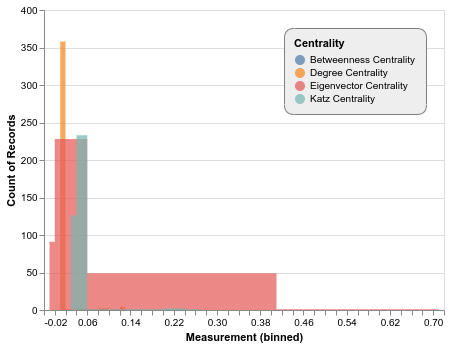

In [114]:
# Generating Data
source = pd.DataFrame({
    'Degree Centrality': list(lDegCentrality.values()),
    'Eigenvector Centrality': list(lEigenVectorCentrality.values()),
    'Betweenness Centrality': list(lBetCentrality.values()),
    'Katz Centrality': list(lKatzCentrality.values())
})

chart = alt.Chart(source).transform_fold(
    ['Degree Centrality', 'Eigenvector Centrality', 'Betweenness Centrality', 'Katz Centrality'],
    as_=['Centrality', 'Measurement']
).mark_area(
    opacity=0.7,
    interpolate='step'
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Centrality:N')
)

chart.configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    orient='top-right'
)

In [115]:
weight_graphFile='weight_repo.graphml'
with open(weight_graphFile, 'wb') as fOut:
    nx.write_graphml(network_weight, fOut)